In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance

df = pd.read_csv("/content/airbnb-listings-cleaned.csv")
df.set_index('id', inplace=True)
pd.options.display.max_columns = 100

Importamos las librerías necesarias para poder trabajar esta práctica final y abrimos el archivo que vamos a utilizar.

# Preprocesado

## Limpieza datos

In [ ]:
datos=df.replace(['f'], 0)
datos=datos.replace(['t'], 1)
datos['neighbourhood_cleansed']= pd.Series(np.where(datos.neighbourhood_cleansed.values == 'Downtown', 1, 0),datos.index)
datos.rename(columns = {'neighbourhood_cleansed':'downtown'}, inplace = True)
datos['host_response_rate'] = datos['host_response_rate'].str.rstrip("%").astype(float)/100
datos['security_deposit'] = datos['security_deposit'].fillna(0)
datos['cleaning_fee'] = datos['cleaning_fee'].fillna(0)
datos['extra_people'] = datos['extra_people'].str.lstrip("$").astype(float)

Hemos reemplazado algunos datos en varias columnas de nuestro Data Frame. Por ejemplo, reemplazamos la "f" de false por un 0 y la "t" de true por un 1. También hemos reconvertido columnas en tipo "float" que es como deben estar las columnas para poder trabjar de forma correcta.

In [ ]:
datos['multipropietario'] = datos['host_id'].duplicated()
datos=datos.replace([True],1)
datos=datos.replace([False],0)

In [ ]:
pd.options.display.max_rows=100
datos.isnull().sum().sort_values(ascending=False)

host_acceptance_rate                            4837
neighbourhood_group_cleansed                    4837
square_feet                                     4759
weekly_price                                    4280
monthly_price                                   4245
host_response_time                              2106
host_response_rate                              2106
license                                         1067
review_scores_value                              708
review_scores_location                           708
review_scores_checkin                            708
review_scores_communication                      707
review_scores_accuracy                           706
review_scores_cleanliness                        705
review_scores_rating                             705
reviews_per_month                                682
last_review                                      682
first_review                                     682
host_neighbourhood                            

Vemos el número de NAs en nuestras columnas y procedemos a su limpieza

In [ ]:
df1= datos.drop(['neighbourhood_group_cleansed', 'host_acceptance_rate', 
                  'square_feet', 'weekly_price', 'monthly_price', 'country_code',
                  'host_id', 'host_name', 'host_location','experiences_offered',
                  'host_neighbourhood', 'city', 'market','neighbourhood',
                  'license', 'zipcode', 'street', 'smart_location', 'country',
                  'calendar_updated', 'has_availability', 'calendar_last_scraped',
                  'is_business_travel_ready','state', 'host_total_listings_count',
                  'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 
                  'maximum_minimum_nights', 'minimum_maximum_nights', 
                  'maximum_maximum_nights', 'availability_60', 'availability_90',
                  'calculated_host_listings_count_entire_homes','require_guest_profile_picture'],axis=1)

Hemos observado los Nan que hay en cada una de las variables para analizar cada una de ellas y para ver que pueden significar sus Nas o ver si su información es relevante y hemos decidido eliminar algunas de ellas porque iban a perjudicar nuestro modelo. Las 5 primeras tienen demasiados valores nulos para sacar modas o medias concluyentes. Después hemos observado que "country_code", "host_id", "host_name" y "host_location" eran columnas irrelevantes. Los valores de "experiences_offered" eran todos None, los de "has_availability" son todo 1, los de "calendar_last_scraped" son todo 4, los de "is_business_travel_ready" son todo 0. "host_total_listings_count" es una columna repetida y las demás variables las hemos eliminado porque tienen unas correlaciones excesivas.

In [ ]:
df1['beds']=df1['beds'].fillna(df1['beds'].mode()[0])
df1['bedrooms']=df1['bedrooms'].fillna(df1['bedrooms'].mode()[0])
df1['host_since']=df1['host_since'].fillna(df1['host_since'].mode()[0])
df1['host_is_superhost']=df1['host_is_superhost'].fillna(df1['host_is_superhost'].mode()[0])
df1['host_listings_count']=df1['host_listings_count'].fillna(df1['host_listings_count'].mode()[0])
df1['host_identity_verified']=df1['host_identity_verified'].fillna(df1['host_identity_verified'].mode()[0])
df1['host_has_profile_pic']=df1['host_has_profile_pic'].fillna(df1['host_has_profile_pic'].mode()[0])
df1['first_review']=df1['first_review'].fillna(df1['first_review'].mode()[0])
df1['last_review']=df1['last_review'].fillna(df1['last_review'].mode()[0])
df1= df1.fillna(df1.mean())

<ipython-input-92-47c109d88041>:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df1= df1.fillna(df1.mean())


En las variables discretas hemos cambiado los NAs por la moda, mientras que en las variables continuas los hemos cambiado por la media.

In [ ]:
tipo_propiedad=pd.get_dummies(df1['property_type'])
tipo_cuarto=pd.get_dummies(df1['room_type'])
tipo_cama=pd.get_dummies(df1['bed_type'])
tipo_cancelacion=pd.get_dummies(df1['cancellation_policy'])
tipo_respuesta=pd.get_dummies(df1['host_response_time'])

In [ ]:
df1['property_type'] = tipo_propiedad['Apartment']
df1.rename(columns = {'property_type':'apartment'}, inplace = True)
df1['house'] = tipo_propiedad['House']
df1['condominium'] = tipo_propiedad['Condominium']
df1['Private_room']= tipo_cuarto['Private room']
df1['real_bed']= tipo_cama['Real Bed']
df1['cancelacion_flexible']=tipo_cancelacion['flexible']
df1['respuesta_rapida']=tipo_respuesta['within an hour']

Hemos creado variables dummies y nos hemos quedado con el valor más representativo de la columna

In [ ]:
from datetime import datetime
df1['host_since'] = df1['host_since'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
df1['host_since'] = df1['host_since'].apply(lambda x: 2023 - x.year)

df1['first_review'] = df1['first_review'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
df1['first_review'] = df1['first_review'].apply(lambda x: 2023 - x.year)

df1['last_review'] = df1['last_review'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
df1['last_review'] = df1['last_review'].apply(lambda x: 2023 - x.year)

Hemos transformado las fechas necesarias en un mismo formato para poder trabajar con ellas correctamente.

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

imputer.fit(df1[["respuesta_rapida"]])
df1["respuesta_rapida"] = imputer.transform(df1[["respuesta_rapida"]]).ravel()

Primero construimos el modelo y después lo ajustamos e imputamos los missing values.

In [ ]:
df2=df1.drop(['bed_type'], axis=1)
df2=df2.drop(['room_type'], axis=1)
df2=df2.drop(['cancellation_policy'], axis=1)
df2=df2.drop(['host_response_time'],axis=1)

Ahora pasamos a analizar la variable precio

In [ ]:
df2['price'].sort_values(ascending=False).head(20)

id
27466923    6500.0
29438764    3850.0
28515801    3601.0
28364428    2950.0
27225802    2850.0
30939442    2651.0
24250201    2400.0
49736       1950.0
31523939    1849.0
28829997    1600.0
31908703    1575.0
31212290    1488.0
24828746    1399.0
24972517    1299.0
30423206    1299.0
27900730    1250.0
30799943    1201.0
5089343     1201.0
16611       1201.0
30587490    1201.0
Name: price, dtype: float64

[]

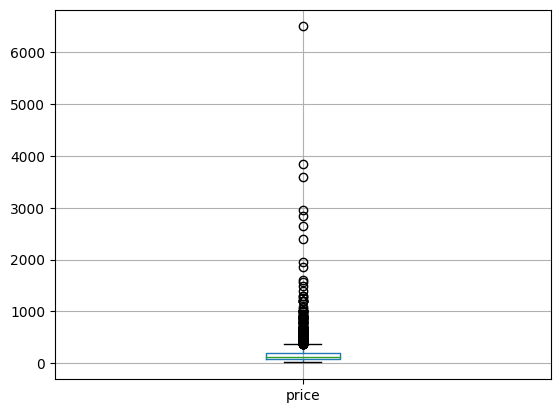

In [ ]:
boxplot = df2.boxplot(column=['price'])
boxplot.plot()

Vemos a partir del boxplot y de los datos anteriores que hay una cantidad excesiva de outliers, por lo que procedemos a su eliminación.

In [ ]:
df2 = df2[df2['price'] < 260]

[]

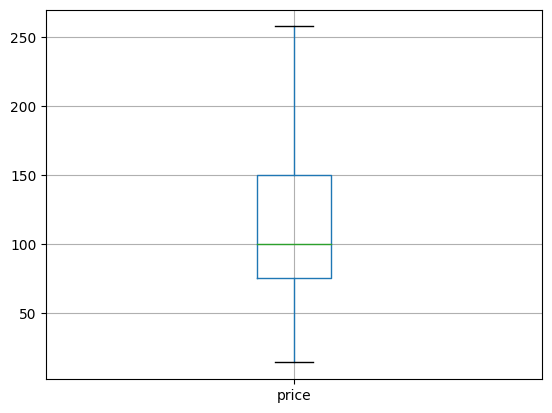

In [ ]:
boxplot = df2.boxplot(column=['price'])
boxplot.plot()

Ahora vemos que limitando el precio a menores de 260 nos quedamos sin outliers

## Correlación

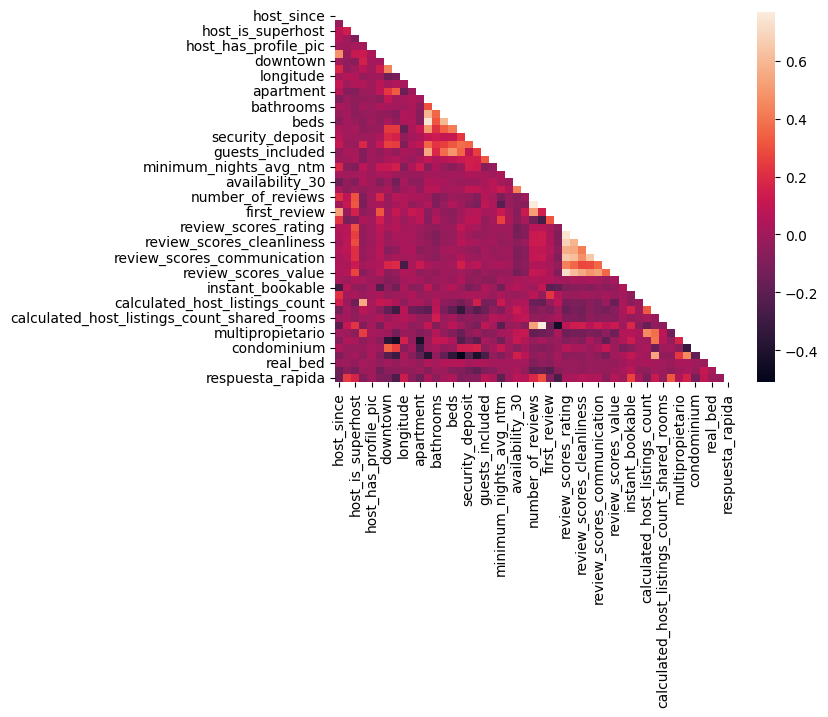

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df2.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask = mask)
corr.style.background_gradient (cmap = 'coolwarm')
plt.show()

In [ ]:
corr_matrix = np.corrcoef(df2.T)
corr_df = pd.DataFrame(data = corr_matrix, columns = df2.columns, index = df2.columns)


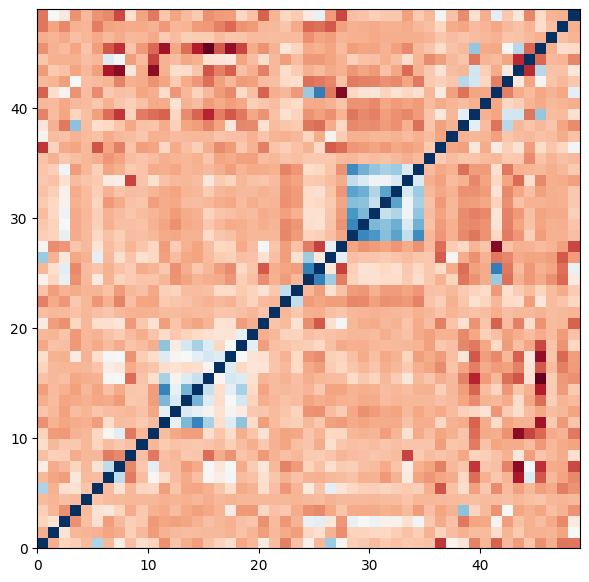

In [ ]:
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.show()

In [ ]:
corr = df2.corr()
corr.style.background_gradient (cmap = 'coolwarm')

,host_since,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,downtown,latitude,longitude,is_location_exact,apartment,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,multipropietario,house,condominium,Private_room,real_bed,cancelacion_flexible,respuesta_rapida
host_since,1.000000,-0.029250,0.075583,0.057076,0.008997,0.478003,-0.000670,0.186809,0.016078,0.106663,0.071386,-0.098991,0.028131,-0.028735,-0.072574,0.025235,0.073639,0.113522,-0.047804,-0.003631,0.184664,0.009651,-0.137153,0.021233,0.207778,-0.005578,0.516924,0.221277,0.059343,0.039244,0.011218,0.049267,0.021348,0.043302,0.035058,0.024668,-0.292324,0.216966,0.147192,-0.130710,-0.003125,-0.201774,0.003371,-0.076174,0.036323,-0.097932,-0.026576,-0.157931,-0.157437
host_response_rate,-0.029250,1.000000,0.134420,-0.004015,-0.008545,-0.021976,-0.053733,-0.033167,0.063572,0.000393,-0.075163,-0.017162,-0.000979,0.009860,0.008092,0.001745,0.002187,-0.015549,0.026867,-0.009384,-0.069933,0.002901,-0.038196,-0.068526,0.080983,0.115719,-0.017883,-0.106122,0.071479,0.071756,0.086249,0.087364,0.061373,0.025893,0.061666,-0.014438,0.072666,0.011796,-0.020355,0.012970,0.008991,0.104104,-0.009747,0.046405,-0.020501,-0.018965,-0.013569,-0.058273,0.247628
host_is_superhost,0.075583,0.134420,1.000000,-0.098810,0.017268,0.115961,-0.071852,0.002019,0.058877,0.040628,-0.081130,-0.051043,-0.065902,-0.052429,-0.022084,0.015561,-0.002934,-0.024206,0.015837,0.027263,-0.097713,0.004590,-0.088037,-0.015076,0.303710,0.322547,0.159418,-0.085331,0.300266,0.250098,0.290856,0.206397,0.206953,0.125645,0.269945,0.044269,-0.039851,0.023840,-0.152555,-0.050682,-0.047459,0.222877,-0.069066,0.021361,-0.025046,0.006804,-0.041652,-0.119586,0.173200
host_listings_count,0.057076,-0.004015,-0.098810,1.000000,0.008537,0.127750,0.157433,0.076615,-0.034003,0.039683,-0.014329,-0.035900,0.011353,-0.039731,-0.061833,-0.046552,-0.013663,0.181444,-0.081225,-0.080682,0.083729,0.023171,0.039746,-0.037274,-0.100270,-0.114607,-0.047249,0.035397,-0.034936,-0.039382,-0.039445,-0.025406,-0.033095,0.006850,-0.074278,0.017636,-0.053226,-0.016135,0.553955,0.076528,0.002664,-0.094122,0.250020,-0.051432,-0.024287,-0.051857,0.016813,-0.014182,-0.091819
host_has_profile_pic,0.008997,-0.008545,0.017268,0.008537,1.000000,0.032085,0.006506,0.002146,-0.002455,-0.003035,-0.002390,-0.022043,-0.013291,-0.020646,-0.002765,-0.028683,-0.004391,-0.015261,-0.005296,-0.004536,-0.007252,-0.006743,-0.002554,-0.012746,0.003094,0.007165,-0.018599,0.003106,-0.000091,0.001788,-0.007006,0.008185,0.008886,0.029591,-0.003863,-0.003757,0.000425,0.005996,0.014736,0.018642,0.003703,0.009799,0.017268,-0.007380,0.018304,0.029191,-0.003811,-0.009763,-0.000960
host_identity_verified,0.478003,-0.021976,0.115961,0.127750,0.032085,1.000000,0.010375,0.136031,-0.002508,0.074770,0.083438,-0.069052,0.034910,-0.044627,-0.055270,-0.020188,0.029633,0.109409,-0.039515,-0.017393,0.111567,0.020765,-0.085157,-0.012666,0.174308,0.028108,0.317495,0.142554,0.086148,0.068152,0.057001,0.076263,0.058304,0.048627,0.067914,-0.030661,-0.231607,0.025712,0.112891,-0.063260,0.041139,-0.114264,0.008217,-0.063920,-0.004923,-0.071322,-0.038863,-0.139557,-0.091485
downtown,-0.000670,-0.053733,-0.071852,0.157433,0.006506,0.010375,1.000000,0.434861,-0.149646,0.009747,0.231325,0.103758,0.013627,-0.041286,0.017361,0.239117,0.187719,0.258712,0.006247,0.026925,0.118771,0.037851,-0.023357,0.022

A través de los siguientes gráficos hemos observado la correlación que existe entre las distintas variables que conforman nuestro Data Frame, y hemos procedido a su eliminación en la parte de arriba del código.

## TRAIN Y TEST

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
x = df2.drop('price', axis = 1)
y = df2['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1357)

In [ ]:
scaler = preprocessing.MinMaxScaler()
normalizedlist=scaler.fit_transform(x_train)
x_train_norm =pd.DataFrame(normalizedlist,columns=x_train.columns)

normalizedlist=scaler.fit_transform(x_test)
x_test_norm =pd.DataFrame(normalizedlist,columns=x_test.columns)

Normalizamos los datos y creamos ambos dataframes

# Modelos

## Regresión lineal

In [ ]:
from sklearn import linear_model
regre_lin = linear_model.LinearRegression()
regre_lin.fit(x_train_norm,y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_regre_lin = mean_squared_error(y_test, regre_lin.predict(x_test_norm), squared=True)
rmse_regre_lin

3062.321641667523

## Regresion logistica

In [ ]:
from sklearn.linear_model import LogisticRegression
regre_log = LogisticRegression()
regre_log.fit(x_train_norm,y_train)
regre_pred_y=regre_log.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
regre_log.score(x_train_norm,y_train)

0.1447098976109215

In [ ]:
rmse_regre_log = mean_squared_error(y_test, regre_log.predict(x_test_norm), squared=True)
rmse_regre_log

2804.621320604614

## GRADIENT BOOST

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

Valor óptimo de n_estimators: 76


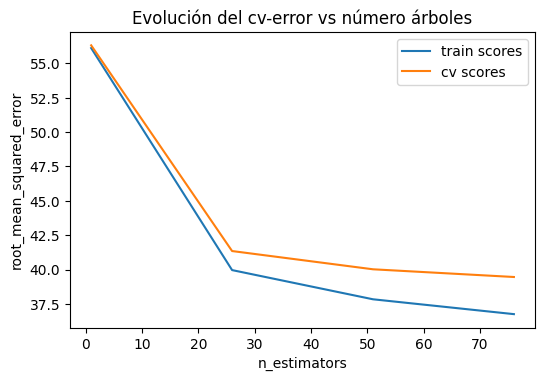

In [ ]:
from sklearn.model_selection import cross_val_score
import multiprocessing

train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 101, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'absolute_error',
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(x_train, y_train)
    predicciones = modelo.predict(X = x_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
boost = GradientBoostingRegressor(n_estimators = 100,
            loss         = 'absolute_error',
            max_features = 'auto',
            random_state = 123)
boost.fit(x_train, y_train)
boost_pred_y=boost.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_gboost = mean_squared_error(y_test, boost.predict(x_test), squared=True)
rmse_gboost

1509.6383759997893

In [ ]:
df_y_test = pd.DataFrame(y_test)
df_y_test['predicted price']= boost_pred_y
df_y_test.head(20)

,price,predicted price
id,,
27222646,97.0,155.089918
29541407,60.0,107.216524
30147059,66.0,67.919138
21581560,140.0,119.760874
28842225,94.0,92.698512
29963882,175.0,170.696638
31021779,50.0,97.418157
31721597,109.0,98.193133
3741866,121.0,122.314572


Vemos como funciona nuestro modelo, y comprobamos que se aproxima bastante a los valores reales.

In [ ]:
df_y_test['Availability_365']=x_test['availability_365']
df_y_test['Availability_30']=x_test['availability_30']
df_y_test['Dif_Price']=df_y_test['price']-df_y_test['predicted price']

In [ ]:
df_y_test

,price,predicted price,Availability_365,Availability_30,Dif_Price
id,,,,,
27222646,97.0,155.089918,79,24,-58.089918
29541407,60.0,107.216524,229,2,-47.216524
30147059,66.0,67.919138,179,30,-1.919138
21581560,140.0,119.760874,245,0,20.239126
28842225,94.0,92.698512,362,28,1.301488
...,...,...,...,...,...
14569204,125.0,110.260070,0,0,14.739930
28498818,150.0,171.404039,0,0,-21.404039
31381243,77.0,98.605678,148,28,-21.605678


<Axes: xlabel='Availability_365', ylabel='Dif_Price'>

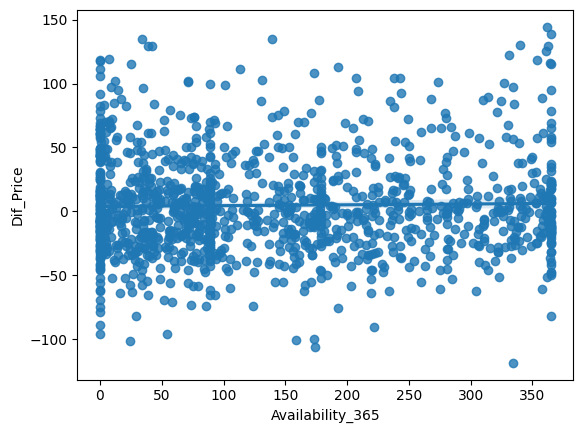

In [ ]:
import seaborn as sns

sns.regplot(y=df_y_test['Dif_Price'], x=df_y_test["Availability_365"])

Tratamos de crear una nueva variable para mejorar nuestro modelo pero vemos que no guarda ninguna relación con la diferencia de precio.

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(x_train_norm,y_train)

KNeighborsRegressor()

In [ ]:
rmse_knn = mean_squared_error(y_test, knn.predict(x_test_norm), squared=True)
rmse_knn

2207.5492442322993

## Árbol de decisión simple

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


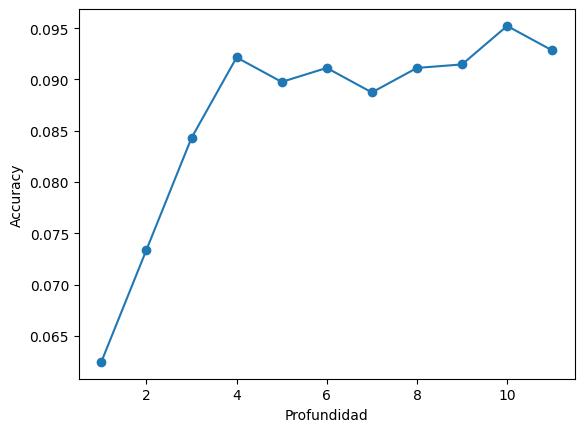

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
Profundidad = range(1,12) 

param_grid = {'max_depth': Profundidad } 
grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(x_train_norm, y_train)

score = np.array(grid.cv_results_['mean_test_score'])
plt.plot(Profundidad,score,'-o')
plt.xlabel('Profundidad')
plt.ylabel('Accuracy')
plt.show()

Vemos que el número idóneo de nodos es 4

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor( max_depth=4)
regressor.fit(x_train_norm,y_train)
data_eval= x_test.copy()

y_pred = regressor.predict(x_test_norm)

In [ ]:
rmse_arbol_simple = mean_squared_error(y_test, regressor.predict(x_test_norm), squared=True)
rmse_arbol_simple

2277.415886563149

Profundidad del árbol: 4
Número de nodos terminales: 16


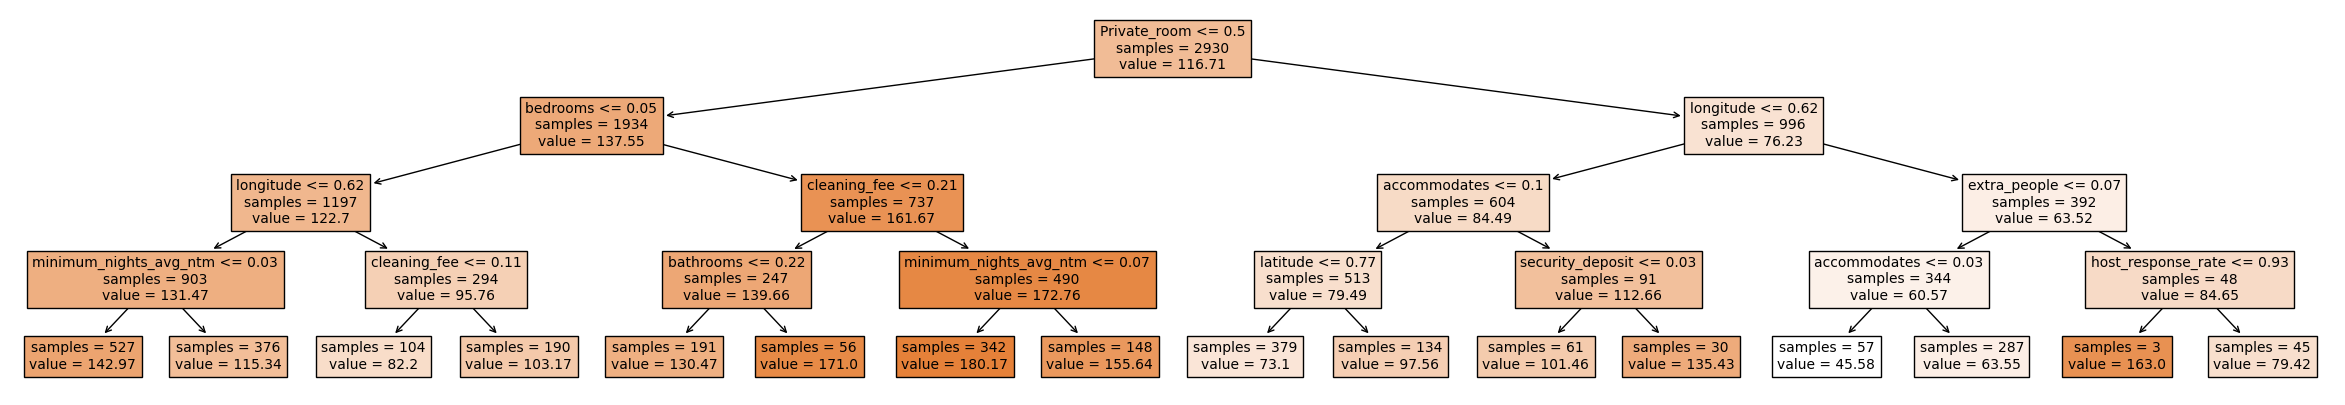

In [ ]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(30, 5))

print(f"Profundidad del árbol: {regressor.get_depth()}")
print(f"Número de nodos terminales: {regressor.get_n_leaves()}")

plot = plot_tree(
            decision_tree = regressor,
            max_depth = 4,
            feature_names = data_eval.columns,
            class_names   = 'price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [ ]:
param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(x_train_norm,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'ccp_alpha': array([ 0.        ,  4.21052632,  8.42105263, 12.63157895, 16.84210526,
       21.05263158, 25.26315789, 29.47368421, 33.68421053, 37.89473684,
       42.10526316, 46.31578947, 50.52631579, 54.73684211, 58.94736842,
       63.15789474, 67.36842105, 71.57894737, 75.78947368, 80.        ])},
             return_train_score=True)

Profundidad del árbol: 13
Número de nodos terminales: 36


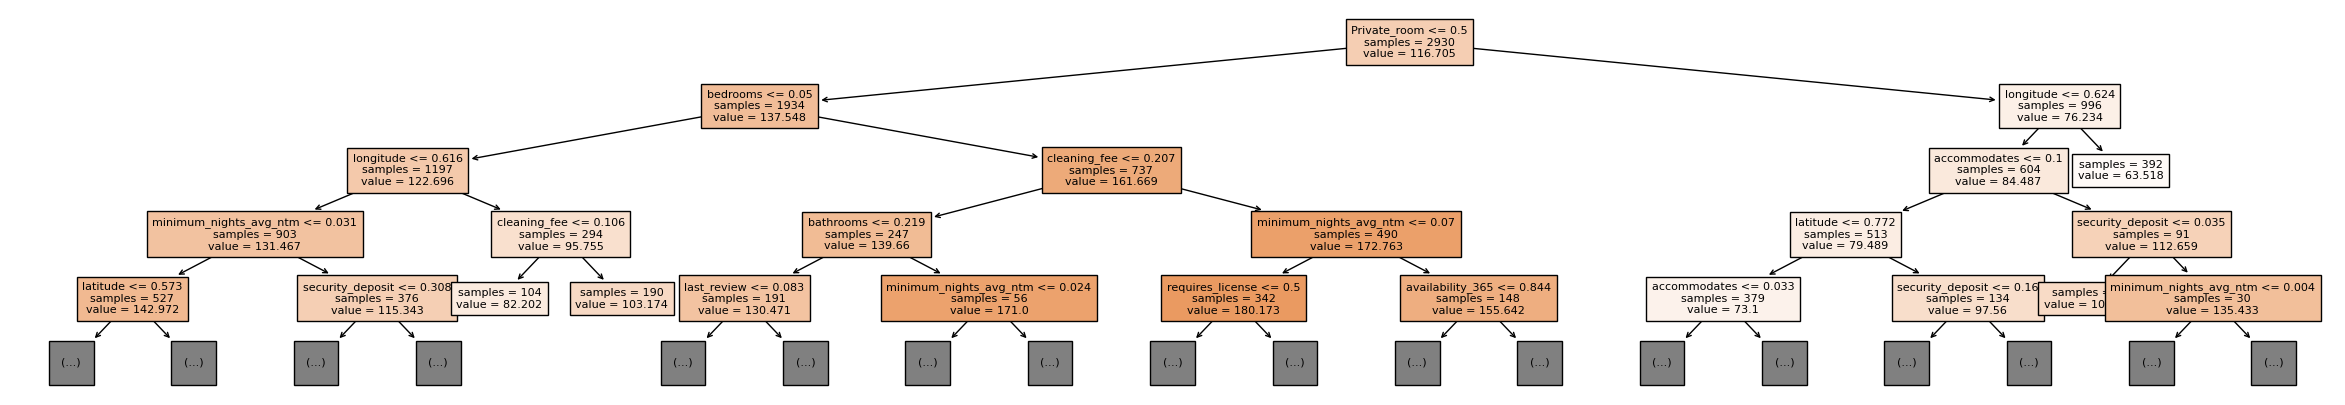

In [ ]:
modelo_final = grid.best_estimator_
modelo_final.predict(x_test)
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(30,5))
plot = plot_tree(
            decision_tree = modelo_final,
            max_depth = 4,
            feature_names = data_eval.columns,
            class_names   = 'price',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            ax            = ax
       )

In [ ]:
rmse_arbol = mean_squared_error(y_test, modelo_final.predict(x_test_norm), squared=True)
rmse_arbol

2428.5158393473625

## Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs

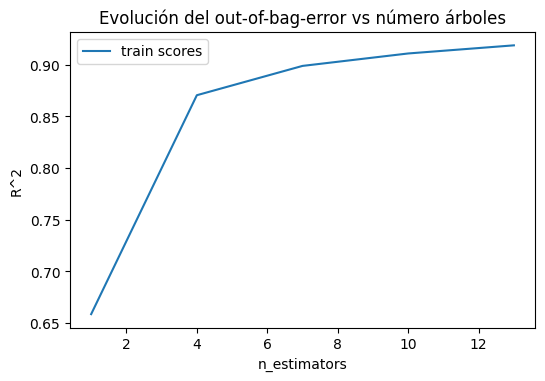

In [ ]:
#Primero analizamos cuántos estimadores debemos utilizar. 

from sklearn.ensemble import RandomForestRegressor

train_scores = []
estimator_range = range(1, 15, 3)

for n_estimators in estimator_range:
    RForestReg = RandomForestRegressor(n_estimators = n_estimators, criterion = 'friedman_mse',
                max_depth = None, max_features = 'auto', oob_score= True,
                n_jobs = -1, random_state = 123)
    RForestReg.fit(x_train_norm, y_train)
    train_scores.append(RForestReg.score(x_train_norm, y_train))

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();

Vemos que el número idóneo de estimadores vuelve a ser 4

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = x_test_norm)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = True)
rmse

7300.615621271789

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rand_for = RandomForestClassifier( n_estimators = 4, max_depth= None, max_features = 'auto',
            oob_score = False, n_jobs = -1, random_state = 123)
rand_for.fit(x_train_norm, y_train)
rand_for_y_pred = rand_for.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


# Conclusión

In [ ]:
tabla = pd.DataFrame()

tabla['Mean Square Error'] = None
tabla['Standar Desviation'] = None

tabla.loc['Regresión Lineal'] = [3062.3216, pow(3062.3216, 1/2)]
tabla.loc['Regresión Logistica'] = [2804.6213, pow(2804.6213, 1/2)]
tabla.loc['Gradient Boost'] = [1509.6383, pow(1509.6383, 1/2)]
tabla.loc['KNN'] = [2207.5492, pow(2207.5492, 1/2)]
tabla.loc['Árbol de decisión'] = [2277.4158, pow(2277.4158, 1/2)]
tabla.loc['Árbol de decisión podado'] = [2428.51, pow(2428.51, 1/2)]
tabla.loc['Random Forest'] = [2428.5158, pow(2428.5158, 1/2)]

tabla

,Mean Square Error,Standar Desviation
Regresión Lineal,3062.3216,55.338247
Regresión Logistica,2804.6213,52.958675
Gradient Boost,1509.6383,38.854064
KNN,2207.5492,46.984563
Árbol de decisión,2277.4158,47.722278
Árbol de decisión podado,2428.5100,49.279915
Random Forest,2428.5158,49.279974


En conclusión, una vez hemos empleado todos los modelos posibles (Regresión Lineal, Regresión Logística, Gradient Boost, KNN, Árbol de Decisión Simple y Random Forest) para ver cual de ellos obtenía mejores resultados y, por tanto, el mejor modelo para representar el evaluador automático de precios creado junto con la menor desviación típica de todos los modelos, hemos observado que este modelo ha sido el "Gradient Boost" con una desviación típica de 38,85.